In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install matplotlib
#!pip install torch>=2.0.0

In [3]:
# uncomment in colab
#!wget -q https://raw.githubusercontent.com/Podidiving/FocallLossTorch/main/loss.py

In [4]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F

from loss import FocalLoss, FocalSmoothLoss, FocalStarLoss


print(torch.__version__)

2.0.0


---

Check that the implementation is consistent with `binary_cross_entropy`

---

In [5]:
fl = FocalLoss(gamma=0.0, alpha=0.0)
fls = FocalSmoothLoss(gamma=0.0, alpha=0.0, smooth=0.0)

In [6]:
# 1-D case

batch_size = 16
num_classes = 10

target = torch.randint(0, num_classes, (batch_size, ))
logits = torch.rand(batch_size, num_classes)
targets = torch.zeros_like(logits).float()
targets[torch.arange(targets.shape[0]), target] = 1.0

loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
print(torch.allclose(loss, fl(logits, target, "none")))
print(torch.allclose(loss, fls(logits, target, "none")))
print(torch.allclose(loss, fls(logits, targets, "none")))

True
True
True


In [7]:
# 3-D case

batch_size = 128
num_classes = 10
h = 16

target = torch.randint(0, num_classes, (batch_size, h, h))
logits = torch.rand(batch_size, num_classes, h, h)
targets = torch.zeros_like(logits)
targets = targets.scatter_(
    1,
    index=target.unsqueeze(1),
    src=torch.ones_like(target.unsqueeze(1)).to(logits))

loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
print(torch.allclose(loss, fl(logits, target, "none")))
print(torch.allclose(loss, fls(logits, target, "none")))
print(torch.allclose(loss, fls(logits, targets, "none")))

True
True
True


check backprop is working

In [8]:
batch_size = 128
num_classes = 10
h = 16

target = torch.randint(0, num_classes, (batch_size, h, h))
logits_ = torch.rand(batch_size, num_classes, h, h)
targets = torch.zeros_like(logits_)
targets = targets.scatter_(
    1,
    index=target.unsqueeze(1),
    src=torch.ones_like(target.unsqueeze(1)).to(logits))

logits = logits_.clone()
logits.requires_grad_()

l = F.binary_cross_entropy_with_logits(logits, targets, reduction="mean")
l.backward()

logits1 = logits_.clone()
logits1.requires_grad_()

l = fl(logits1, target, "mean")
l.backward()

logits2 = logits_.clone()
logits2.requires_grad_()

l = fls(logits2, target, "mean")
l.backward()

logits3 = logits_.clone()
logits3.requires_grad_()

l = fls(logits3, targets, "mean")
l.backward()

print(torch.allclose(logits1.grad.data, logits2.grad.data))
print(torch.allclose(logits1.grad.data, logits3.grad.data))
print(torch.allclose(logits1.grad.data, logits.grad.data))

True
True
True


---

\+ compare with [fvcore](https://github.com/facebookresearch/fvcore) implementation

---

In [9]:
# https://github.com/facebookresearch/fvcore/blob/main/fvcore/nn/focal_loss.py

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = -1,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    inputs = inputs.float()
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

In [11]:
batch_size = 128
num_classes = 10
h = 16

target = torch.randint(0, num_classes, (batch_size, h, h))
logits = torch.rand(batch_size, num_classes, h, h)
targets = torch.zeros_like(logits)
targets = targets.scatter_(
    1,
    index=target.unsqueeze(1),
    src=torch.ones_like(target.unsqueeze(1)).to(logits))

for gamma in torch.linspace(0.0, 5.0, 50):
    for alpha in [-1.0, 0.25, 0.5]:
        fl = FocalLoss(gamma=gamma, alpha=alpha)
        fls = FocalSmoothLoss(gamma=gamma, alpha=alpha, smooth=0.0)
        l1 = fl(logits, target, "none")
        l2 = fls(logits, target, "none")
        l3 = sigmoid_focal_loss(logits, targets, alpha=alpha, gamma=gamma, reduction="none")
        assert torch.allclose(l1, l2)
        assert torch.allclose(l1, l3)

seems to be working

---

Next thing is to make plots that resemble the one in the original paper

---

In [10]:
gammas = [0, 0.5, 1, 2, 5]
alpha = 0.0

batch_size = 128
num_classes = 10

prob_space = torch.linspace(0.01, 0.9999, 500)
losses = dict()

for gamma in gammas:
    fl = FocalLoss(gamma, alpha)

    target_ = torch.randint(0, num_classes, (batch_size, ))
    std = 0.5
    logits_ = torch.rand(batch_size, num_classes) * std
    losses[gamma] = []
    
    for probability in prob_space:
        target = target_.clone()
        
        logit_gt = -torch.log(torch.clamp(1 / (probability + 1e-9) - 1, 1e-9))

        logits = torch.zeros_like(logits_)
        logits[torch.arange(batch_size), target] = logit_gt
        logits = logits + logits_
    
        loss = fl(logits, target, "none")
        losses[gamma].append(loss[torch.arange(batch_size), target].mean().item())

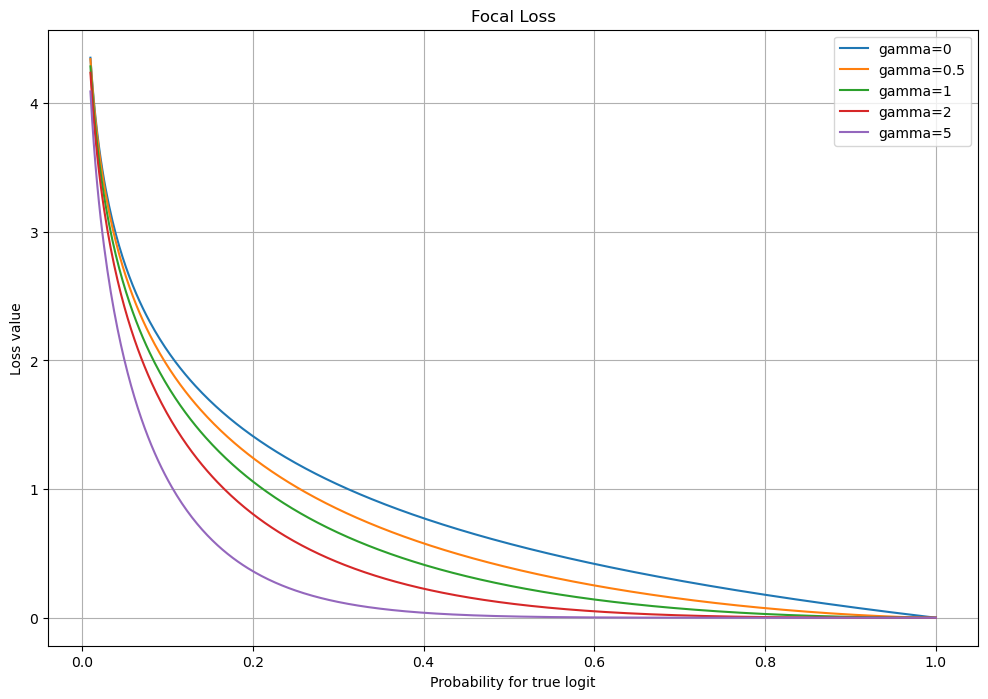

In [12]:
plt.figure(figsize=(12, 8))

for gamma in gammas:
    plt.plot(prob_space, losses[gamma], label=f"gamma={gamma}")
plt.legend()
plt.title("Focal Loss")
plt.ylabel("Loss value")
plt.xlabel("Probability for true logit")
plt.grid()
plt.show()

In [13]:
gammas = [0, 0.5, 1, 2, 5]
alpha = 0.0

batch_size = 128
num_classes = 10

prob_space = torch.linspace(0.01, 0.9999, 500)
losses_smooth = dict()

smooth_coefs = [0.01, 0.05, 0.1, 0.2, 0.3]
for smooth_coef in smooth_coefs:
    losses_smooth[smooth_coef] = dict()
    for gamma in gammas:
        fl = FocalSmoothLoss(gamma, alpha, smooth=smooth_coef)

        target_ = torch.randint(0, num_classes, (batch_size, ))
        std = 0.5
        logits_ = torch.rand(batch_size, num_classes) * std
        losses_smooth[smooth_coef][gamma] = []
        
        for probability in prob_space:
            target = target_.clone()
            
            logit_gt = -torch.log(torch.clamp(1 / (probability + 1e-9) - 1, 1e-9))

            logits = torch.zeros_like(logits_)
            logits[torch.arange(batch_size), target] = logit_gt
            logits = logits + logits_
        
            loss = fl(logits, target, "none")
            losses_smooth[smooth_coef][gamma].append(loss[torch.arange(batch_size), target].mean().item())

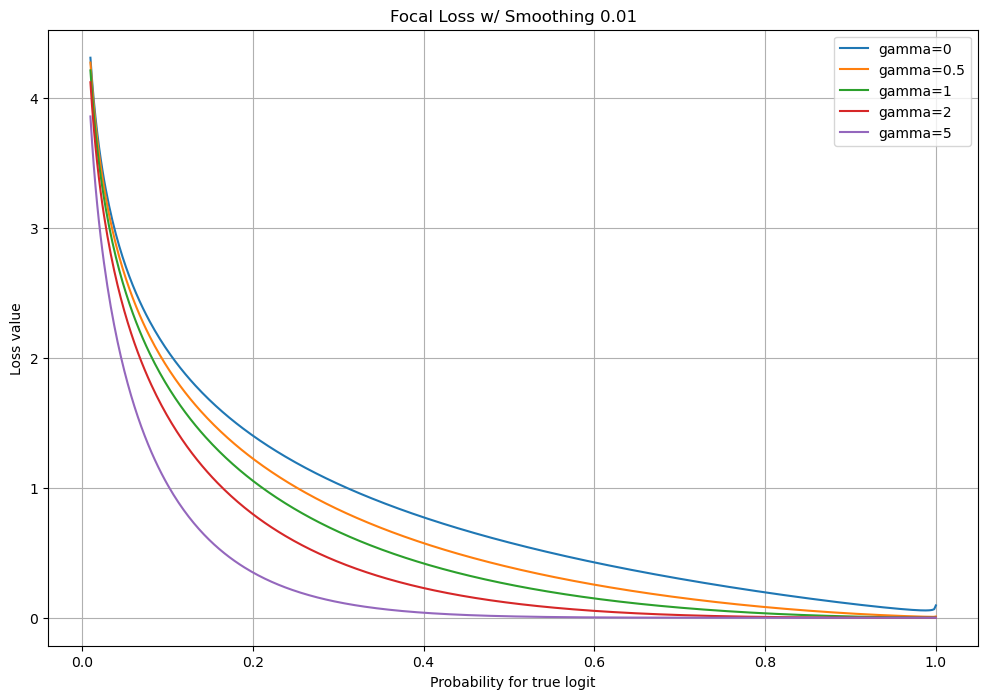

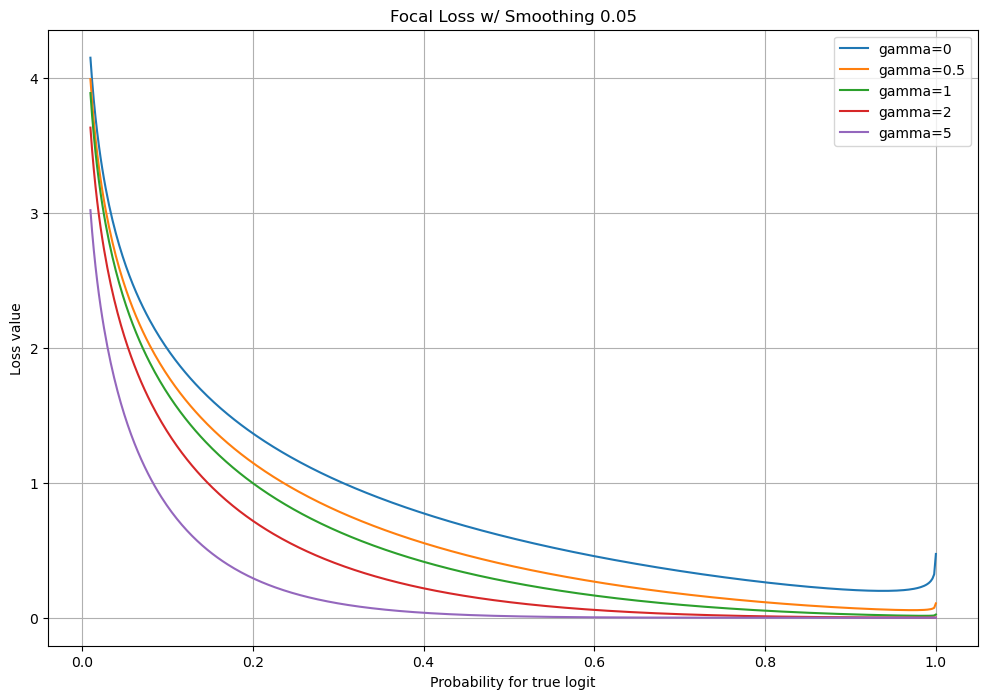

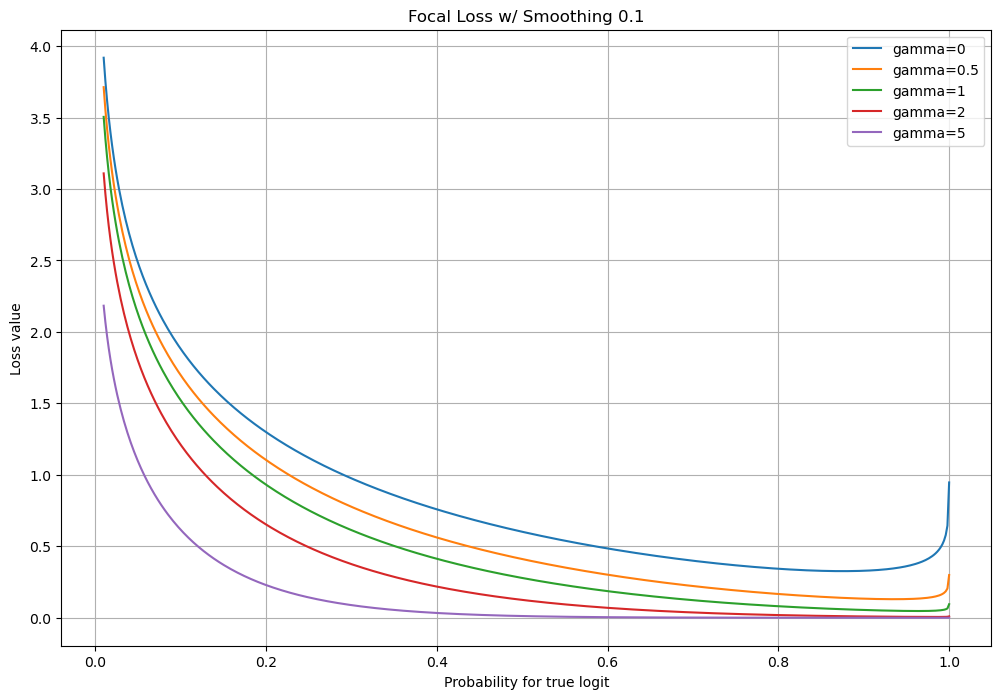

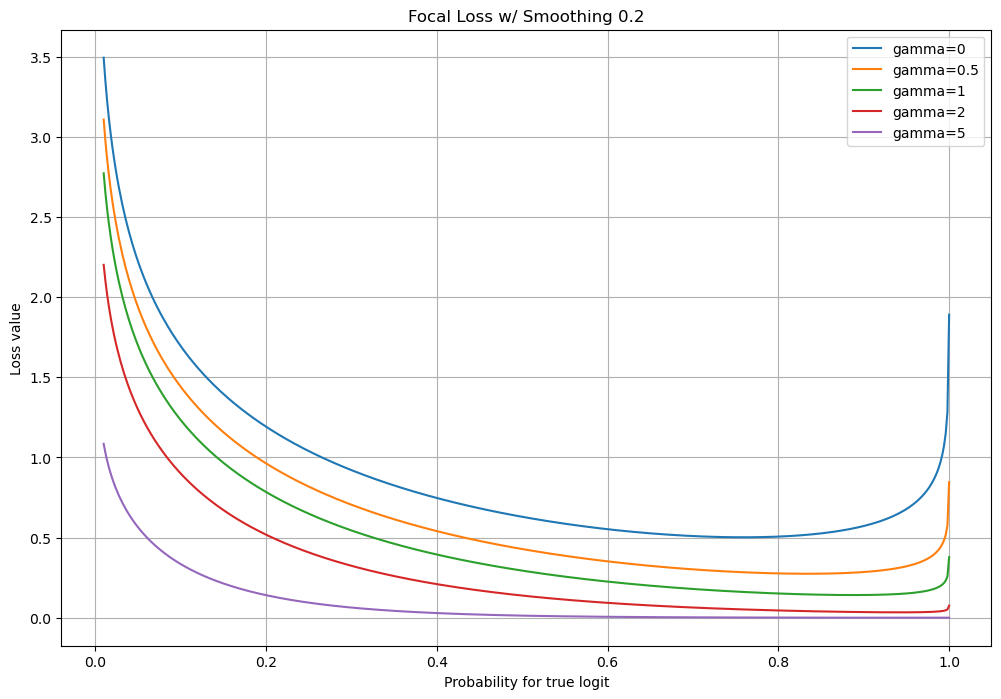

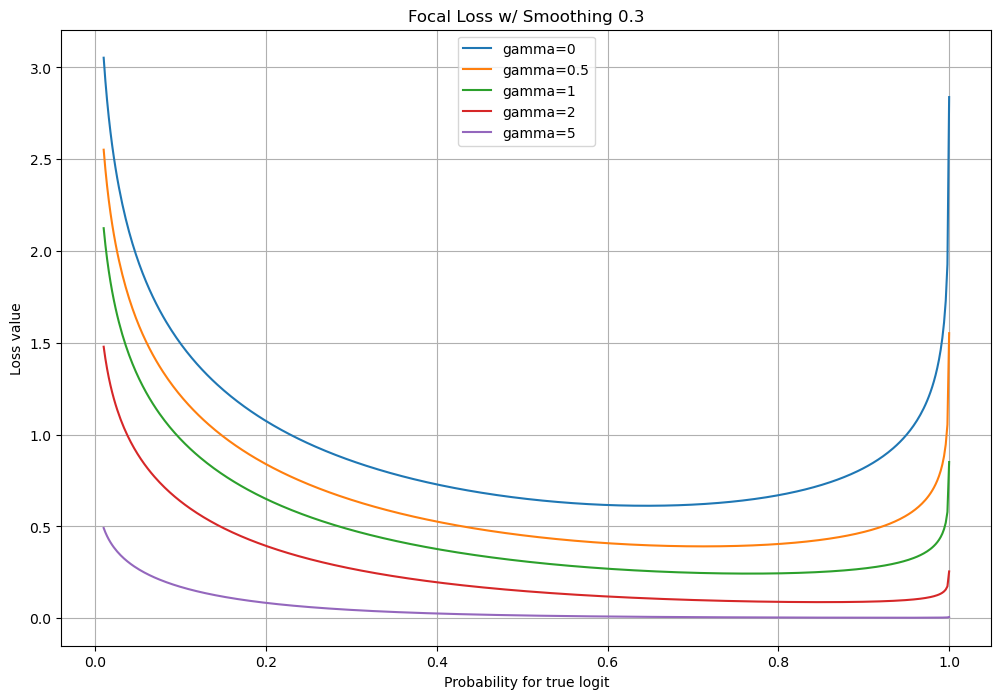

In [15]:
for smooth_coef in smooth_coefs:
    plt.figure(figsize=(12, 8))

    for gamma in gammas:
        plt.plot(prob_space, losses_smooth[smooth_coef][gamma], label=f"gamma={gamma}")
    plt.legend()
    plt.title(f"Focal Loss w/ Smoothing {smooth_coef}")
    plt.ylabel("Loss value")
    plt.xlabel("Probability for true logit")
    plt.grid()
    plt.show()

Let's see the ends of the tails

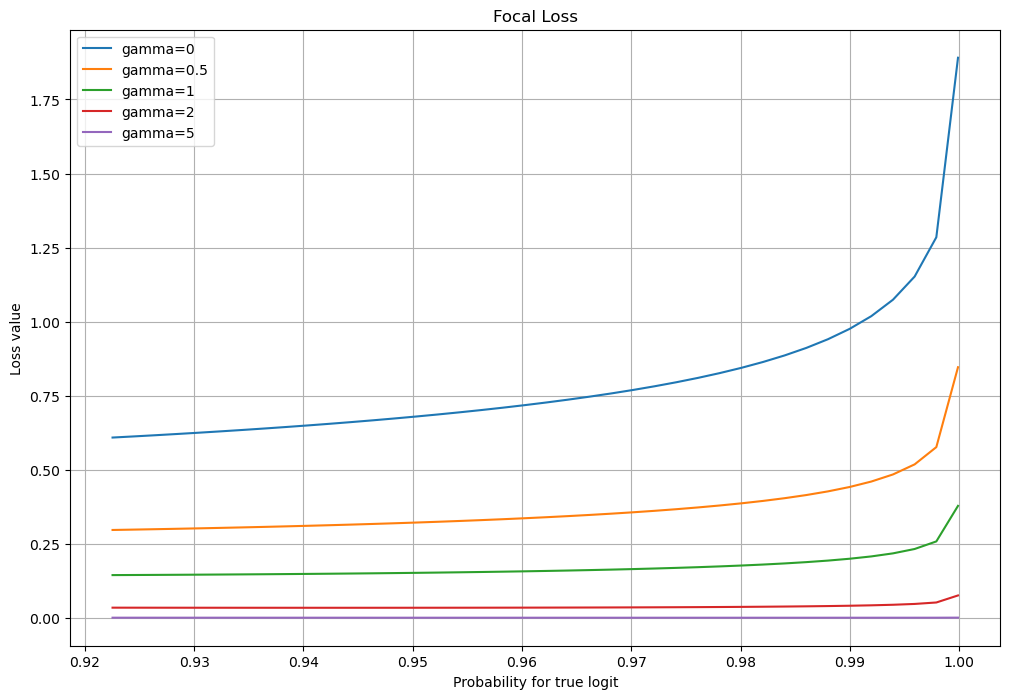

In [14]:
plt.figure(figsize=(12, 8))

last = -40
for gamma in gammas:
    plt.plot(prob_space[last:], losses_smooth[smooth_coefs[-2]][gamma][last:], label=f"gamma={gamma}")
plt.legend()
plt.title("Focal Loss")
plt.ylabel("Loss value")
plt.xlabel("Probability for true logit")
plt.grid()
plt.show()

It's quite interesting that smoothing seems to be working with only cross-entropy (`gamma=0.0`)

(Well, it's quite intuitive, because FL and Smoothing are both techniques to alleviate overfitting. But I believe that sometimes in practice in may be beneficial to use them both.)

----

FL*

In [16]:
gammas = [0.5, 1, 2, 5]
betas = [0.0, 1.0]
alpha = 0.0

batch_size = 128
num_classes = 10

prob_space = torch.linspace(0.01, 0.9999, 500)
losses_star = dict()

for beta in betas:
    losses_star[beta] = dict()
    for gamma in gammas:
        fl = FocalStarLoss(gamma, alpha, beta)

        target_ = torch.randint(0, num_classes, (batch_size, ))
        std = 0.5
        logits_ = torch.rand(batch_size, num_classes) * std
        
        losses_star[beta][gamma] = []
        
        for probability in prob_space:
            target = target_.clone()
            
            logit_gt = -torch.log(torch.clamp(1 / (probability + 1e-9) - 1, 1e-9))

            logits = torch.zeros_like(logits_)
            logits[torch.arange(batch_size), target] = logit_gt
            logits = logits + logits_
        
            loss = fl(logits, target, "none")
            losses_star[beta][gamma].append(loss[torch.arange(batch_size), target].mean().item())

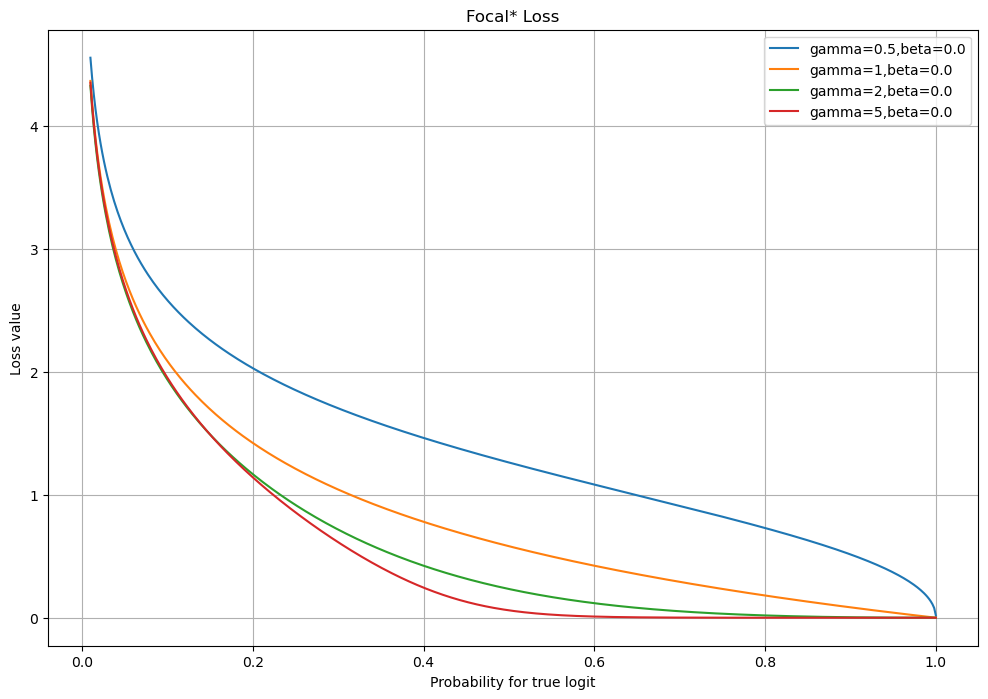

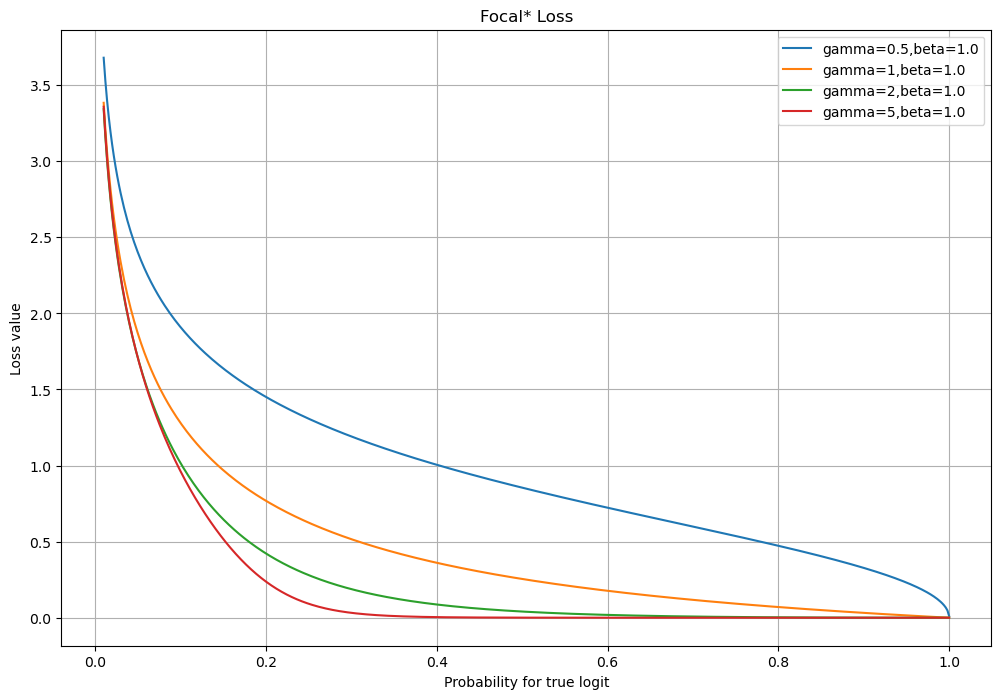

In [18]:
for beta in betas:
    plt.figure(figsize=(12, 8))

    for gamma in gammas:
        plt.plot(prob_space, losses_star[beta][gamma], label=f"gamma={gamma},beta={beta}")
    plt.legend()
    plt.title(f"Focal* Loss")
    plt.ylabel("Loss value")
    plt.xlabel("Probability for true logit")
    plt.grid()
    plt.show()

All together (quite messy)

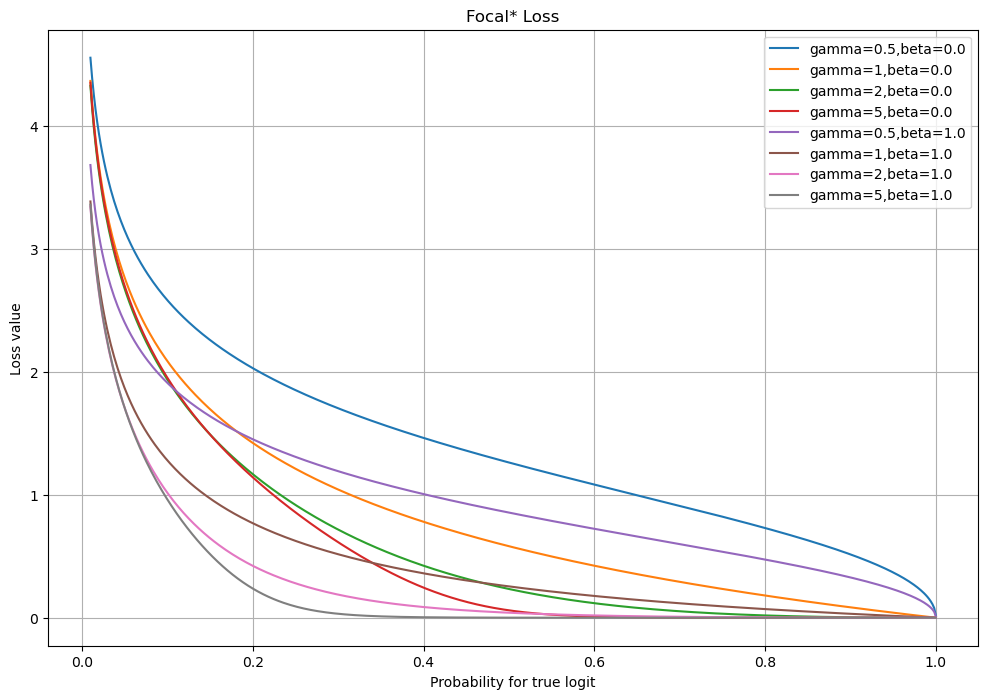

In [17]:
plt.figure(figsize=(12, 8))

for beta in betas:

    for gamma in gammas:
        plt.plot(prob_space, losses_star[beta][gamma], label=f"gamma={gamma},beta={beta}")
plt.legend()
plt.title(f"Focal* Loss")
plt.ylabel("Loss value")
plt.xlabel("Probability for true logit")
plt.grid()
plt.show()

---

With that being done, my tiny report is done.

Use it if you want 😘

P.s. I checked them on `cpu`, `cuda`, and `mps`. Seems to be working. Yay